# Handout #4: Unsupervised Learning (hierarchical clustering)

In [15]:
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt

In [17]:
group = '03' # assuming group 1
ds = 5 # assuming problems 5
data = np.loadtxt(f'ds{group}{str(ds)}.txt')
X = data[:, 0:2]
y = data[:, 2]

## Pintado de datos con etiquetas originales 

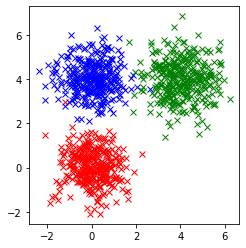

In [19]:
def draw_dataset(data):
    plt.subplot(111,aspect=1)
    w_0 = data[data[:,2] == 0]
    w_1 = data[data[:,2] == 1]
    w_2 = data[data[:,2] == 2]
    plt.plot(w_0[:,0], w_0[:,1], 'rx')
    plt.plot(w_1[:,0], w_1[:,1], 'bx');
    plt.plot(w_2[:,0], w_2[:,1], 'gx');
    
draw_dataset(data)

## Soluciones

In [148]:
def draw_clusters(X, labels):
    

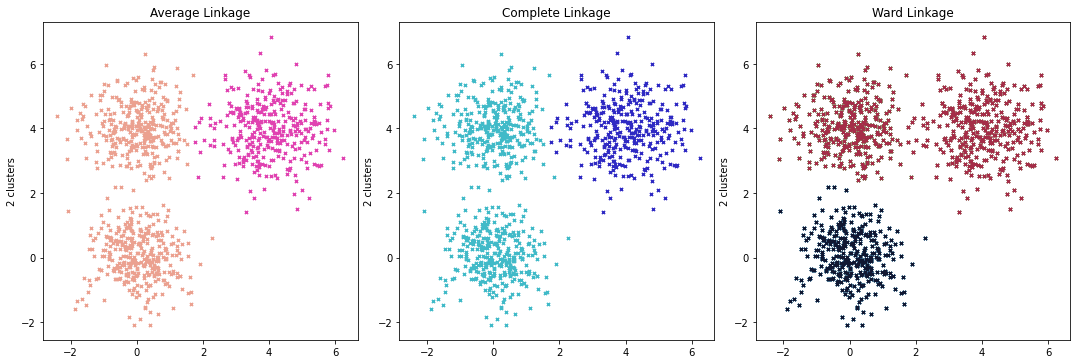

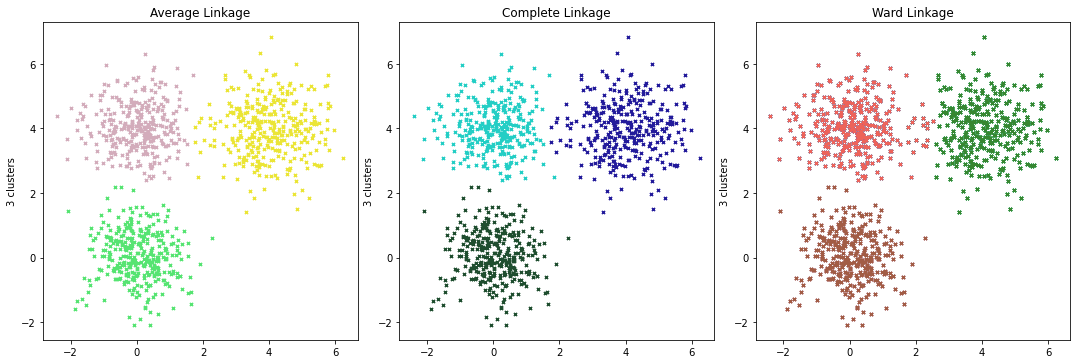

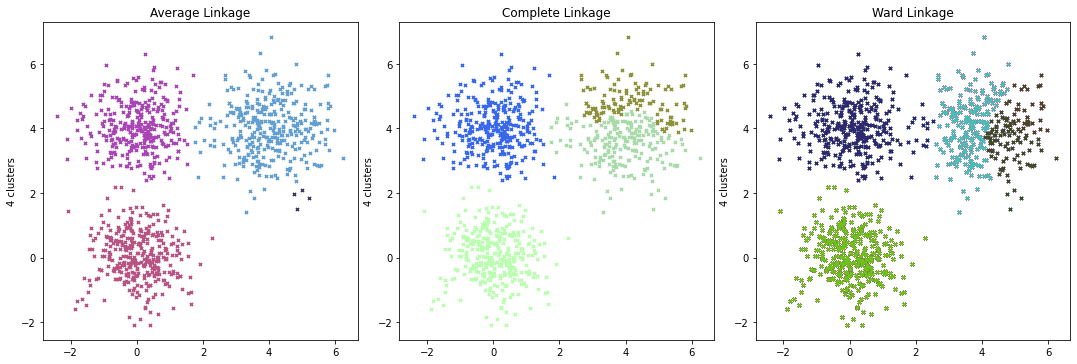

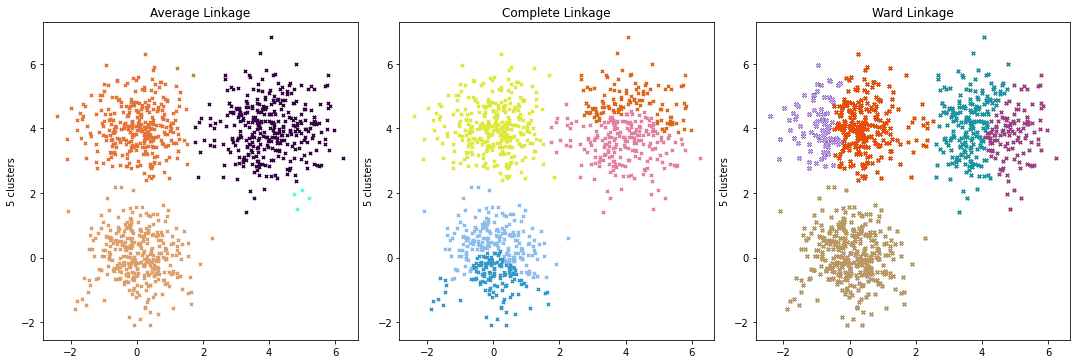

In [181]:
number_of_cluster_list = [2, 3, 4, 5]

for n_clusters in number_of_cluster_list:
    f, axs = plt.subplots(1, len(clustering_algorithms), figsize = (15, 5))
    f.tight_layout()

    complete = cluster.AgglomerativeClustering(
        n_clusters = n_clusters, linkage = "complete"
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters = n_clusters, linkage = "ward"
    )
    average = cluster.AgglomerativeClustering(
        n_clusters = n_clusters, linkage = "average"
    )

    clustering_algorithms = (
        ("Average Linkage", average),
        ("Complete Linkage", complete),
        ("Ward Linkage", ward)
    )


    plot_num = 0

    for name, model in clustering_algorithms:
        model.fit(X)
        labels = model.labels_
        draw_clusters(X, labels)        
        distinct_labels = list(set(labels))
    
        for label in distinct_labels:
            axs[plot_num].set_title(name)
            axs[plot_num].set(ylabel = str(n_clusters) + ' clusters')

            axs[plot_num].scatter(X[labels == label, 0], X[labels == label, 1], s = 10, marker = 'x', color = np.random.rand(3,))
            
        plot_num = plot_num + 1